# Fake Data Studies

In [1]:
nuwro = False
ISRUN3 = False
cut_level = ""

In [2]:
# python notebook to study NuWro fake data distributions
# need to do manual ppfx correction weights

In [3]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

import cfg
from cfg import *

import top 
from top import *

importlib.reload(sf)
from selection_functions import *

Welcome to JupyROOT 6.26/10


In [4]:
import json

In [5]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

In [6]:
if nuwro: 
    path = '/Users/abarnard/phd/pelee_ntuples/run1/slimmed/'

else: 
    if not ISRUN3:
        path = '/Users/abarnard/phd/pelee_ntuples/run1/slimmed/'
    else: 
        path = '/Users/abarnard/phd/pelee_ntuples/run3b/slimmed/'


In [7]:
if nuwro: 
    overlay = uproot.open(path+"neutrinoselection_filt_run1_overlay_nuwro.root")[fold][tree]
    nue = uproot.open(path+"neutrinoselection_filt_run1_overlay_nuwro_intrinsic.root")[fold][tree]
  
else: 
    if not ISRUN3: 
        overlay = uproot.open(path+"neutrinoselection_filt_run1_overlay_v7.root")[fold][tree]
        nue = uproot.open(path+"neutrinoselection_filt_run1_overlay_intrinsic_v7.root")[fold][tree]
    else: 
        overlay = uproot.open(path+"neutrinoselection_filt_run3b_overlay_v7.root")[fold][tree]
        nue = uproot.open(path+"neutrinoselection_filt_run3b_overlay_intrinsic_v7.root")[fold][tree]
    
uproot_v = [overlay,nue]

In [8]:

variables = [
    "selected", "nu_pdg", 
    "trk_score_v", 
    "shr_tkfit_dedx_Y",
    "ccnc", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "nproton", "nu_e", "n_showers_contained",
    "shr_score", 
    "trk_energy", "tksh_distance", "tksh_angle",
    "npi0", 
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice",
    "contained_fraction",
    "npion", 
    "shrmoliereavg", 
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", 
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", "true_e_visible", "trkshrhitdist2", 
    "weightSplineTimesTune", "weightTune", "true_nu_px", "true_nu_py", "true_nu_pz", 
    "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
    "swtrig_pre", "ppfx_cv", "mc_pdg",  'interaction', 'run', "opening_angle"]

In [9]:
overlay = overlay.pandas.df(variables, flatten=False)

In [10]:
nue = nue.pandas.df(variables, flatten=False)

In [11]:
df_v = [overlay,nue]

In [12]:
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000

    # Correction for reconstructed electron energy (not in Katrina's original script)
    # This needs to be df, not nue! 
    df['shr_energy_cali'] = df['shr_energy_cali']/0.83


In [13]:
overlay = overlay.query('swtrig_pre==1')
nue = nue.query('swtrig_pre==1')

In [14]:
mc_df = [overlay, nue]

In [15]:
for i,df in enumerate(mc_df):
    
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    # We don't need the below, as these have been accounted for in the file prep. 
    
    # Add truth level theta & phi angles (detector & beam coordinates)
    #df = addAngles(df)
    
    # add binned ppfx weights
    #if nuwro: 
        #df = offline_flux_weights(df, ISRUN3)
    

/var/folders/pj/m9tfv03972l1ccvgzxkhhrdh0000gq/T/ipykernel_34499/245918929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = np.where((df.swtrig_pre == 1)


In [16]:
print(len(nue.query('is_signal==True'))==len(nue.query(signal)))
print(len(nue.query('is_signal==False'))==len(nue.query(not_signal)))

True
True


## Weights

In [17]:
# clean bad weights & values 
# Have added in the sanity checks for the ppfx_cv weights here! 

for i,df in enumerate(mc_df):
    
    # ppfx_cv cleaning here
    df.loc[ df['ppfx_cv'] <= 0, 'ppfx_cv' ] = 1.
    df.loc[ df['ppfx_cv'] == np.inf, 'ppfx_cv' ] = 1.
    df.loc[ df['ppfx_cv'] > 30, 'ppfx_cv' ] = 1.
    df.loc[ np.isnan(df['ppfx_cv']) == True, 'ppfx_cv' ] = 1.
     
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 30, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 30, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  

     

In [18]:
# scale down the number of events to match data POT 

#nue = nue[:round(len(nue)*0.0119)]
#overlay = overlay[:round(len(overlay)*0.301)]

In [19]:
# POT normalization - scale to data 

if ISRUN3: 
    data_pot = 5.014E20
else: 
    data_pot = 2.0E20

if nuwro==True: 
    overlay['pot_scale'] = data_pot/6.64422e+20
    nue['pot_scale'] = data_pot/1.68375e+22

else: 
    overlay = pot_scale(overlay, 'overlay', ISRUN3)
    nue = pot_scale(nue, 'intrinsic', ISRUN3)
    
    #overlay['pot_scale'] = data_pot/2.33652e+21
    #nue['pot_scale'] = data_pot/2.37838e+22


Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....


In [20]:
# Keep the ppfx_cv weights in here!

if nuwro: # does not get the genie tune weight 

    overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']

else: 
    
    overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']*overlay['weightSplineTimesTune']
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']*nue['weightSplineTimesTune']

print(nue['ppfx_cv'])

entry
0        1.031478
1        0.474253
2        0.974555
3        1.060445
4        0.864058
           ...   
65069    0.650089
65070    0.897917
65071    0.653475
65072    0.389150
65073    0.524179
Name: ppfx_cv, Length: 65074, dtype: float32


## Categories

In [21]:
print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
len1 = len(overlay)
    
idx = overlay.query(nueCC_query).index
overlay.drop(idx, inplace=True)
len2 = len(overlay) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
# then add in nue_intrinsic 
overlay = pd.concat([overlay,nue], ignore_index=True)

# from here on out everything else should be the same. 

# of nueCC in AV in overlay sample = 6163
# of nueCC in AV dropped in overlay = 6163


In [22]:
# separate by in/out FV & cosmic
infv = overlay.query(in_fv_query)
outfv = overlay.query(out_fv_query)

In [23]:
# check that everything is accounted for 
print(len(overlay)==len(infv)+len(outfv))

True


In [24]:
tot_signal_weighted = np.nansum(infv.query('is_signal==True')['pot_scale'])
print('total signal events = '+ str(tot_signal_weighted))


total signal events = 243.37574315290246


In [25]:
datasets = {
    'infv' : infv, 
    'outfv' : outfv
}

In [26]:
# This needs to be uncommented for the rest of the script to work!

if nuwro: 
    generated_events = pd.concat([datasets['outfv'], datasets['infv']])

## BDT selection

In [27]:
datasets_bdt = {}

bdt_score_cut = parameters(ISRUN3)['bdt_score_cut']
selected_query = BDT_LOOSE_CUTS +' and BDT_score>'+str(bdt_score_cut)
selected_signal_query = 'is_signal==True and '+BDT_LOOSE_CUTS+' and BDT_score>'+str(bdt_score_cut)
    
#print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

print(selected_query)

swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score>0.55


In [28]:
# load bdt model 
split = 1
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3)['bdt_model'])

for i in range(len(datasets)): 

    df = list(datasets.values())[i].copy()
    df = df.query(BDT_LOOSE_CUTS)

    # clean datasets 
    for column in training_parameters:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[training_parameters])

    # apply the bdt selection
    preds = bdt_model.predict(df_test)

    # add columns for plotting 
    df['BDT_score'] = preds

    datasets_bdt[list(datasets.keys())[i]] = df.query(selected_query)

/Users/abarnard/miniforge3/envs/ccnpenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1070: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  warnings.warn(smsg, UserWarning)


In [29]:
datasets_bdt.keys()

dict_keys(['infv', 'outfv'])

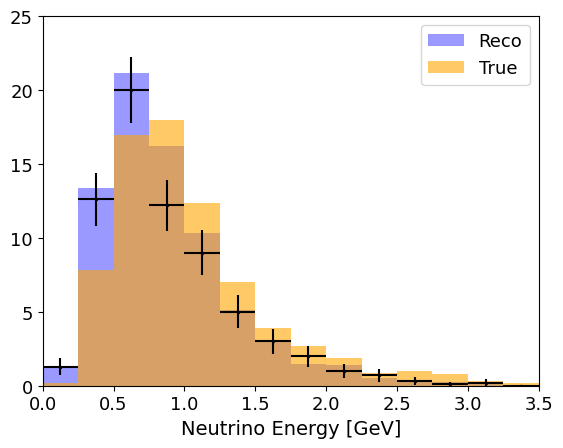

In [30]:
bincenters = 0.5*(np.array([x*0.25 for x in range(15)])[1:]+np.array([x*0.25 for x in range(15)])[:-1])
binwidth = []
    
n = plt.hist(datasets_bdt['infv'].NeutrinoEnergy2_GeV, [x*0.25 for x in range(15)], 
         color='blue',label='Reco', alpha=0.4, weights=datasets_bdt['infv'].totweight_data)[0]

plt.hist(datasets_bdt['infv'].true_e_visible, [x*0.25 for x in range(15)],
         color='orange',label='True', alpha=0.6, weights=datasets_bdt['infv'].totweight_data)

fake_data = [ 1.3, 12.6, 20, 12.2,  9, 5,  3,  2,  1,  .7, .3,  .1,  .2,  .001]
plt.errorbar(bincenters, fake_data, 
             xerr=0.125, yerr=[np.sqrt(x)/2 for x in fake_data], 
             fmt='.', 
             color='black', ecolor='black', markersize=3, label='') 


plt.xlabel("Neutrino Energy [GeV]", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks([0, 5, 10, 15, 20, 25],fontsize=13)
plt.legend(fontsize=13)
plt.xlim(0, 3.5)
plt.ylim(0, 25)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fake_withdata.pdf", 
            #transparent=True, bbox_inches='tight')


plt.show()

## Selected distributions

In [31]:
name_of_variable = "Electron Energy" 
xvar, true_var, bins, xlow, xhigh, x_label, x_ticks = get_variable_info(name_of_variable, ISRUN3, cut_level)

if xvar=='tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])

else: 
    bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])


From cfg.py...
Variable definition: Electron Energy
Reconstructed variable = shr_energy_cali
True variable = elec_e
Bins = [0.02, 0.22, 0.42, 0.62, 0.82, 1.22, 7.0]
Lowest x-value on plot = 0.02
Highest x-value on plot = 2.5
x-axis title = Electron Energy [GeV]
x-axis labels = [0.02, 0.22, 0.42, 0.62, 0.82, 1.22]


In [32]:
leg = {
        'outfv' : labels['outfv'][0]+': ' + str( round(sum(datasets_bdt['outfv'].totweight_data), 1)) , 
        'numu_NC_Npi0' : labels['numu_NC_Npi0'][0]+': '+ str( round(sum(datasets_bdt['infv'].query(numu_NC_Npi0).totweight_data), 1)), 
        'numu_CC_Npi0' : labels['numu_CC_Npi0'][0]+': '+str( round(sum(datasets_bdt['infv'].query(numu_CC_Npi0).totweight_data), 1)), 
        'numu_NC_0pi0' : labels['numu_NC_0pi0'][0]+': '+str( round(sum(datasets_bdt['infv'].query(numu_NC_0pi0).totweight_data), 1)), 
        'numu_CC_0pi0' : labels['numu_CC_0pi0'][0]+': '+str( round(sum(datasets_bdt['infv'].query(numu_CC_0pi0).totweight_data), 1)), 
        'nue_NC' : labels['nue_NC'][0]+': '+str( round(sum(datasets_bdt['infv'].query(nue_NC).totweight_data), 1)), 
        'nue_CCother' : labels['nue_CCother'][0]+': '+str( round(sum(datasets_bdt['infv'].query(nue_CCother).totweight_data), 1)),
        'nuebar_1eNp' : labels['nuebar_1eNp'][0]+': '+str( round(sum(datasets_bdt['infv'].query(nuebar_1eNp).totweight_data), 1)), 
        'signal' : labels['signal'][0]+': '+str( round(sum(datasets_bdt['infv'].query(signal).totweight_data), 1))
    }

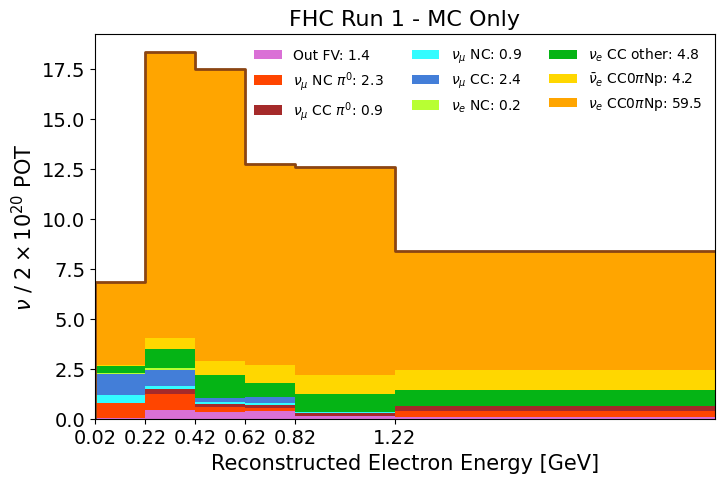

In [33]:
fig = plt.figure(figsize=(8, 5))

n, b, p = plt.hist([datasets_bdt['outfv'][xvar], 
                       datasets_bdt['infv'].query(numu_NC_Npi0)[xvar],
                       datasets_bdt['infv'].query(numu_CC_Npi0)[xvar],
                       datasets_bdt['infv'].query(numu_NC_0pi0)[xvar],
                       datasets_bdt['infv'].query(numu_CC_0pi0)[xvar],
                       datasets_bdt['infv'].query(nue_NC)[xvar],
                       datasets_bdt['infv'].query(nue_CCother)[xvar],
                       datasets_bdt['infv'].query(nuebar_1eNp)[xvar], 
                       datasets_bdt['infv'].query(signal)[xvar]],
            bins, histtype='bar', range=[xlow, xhigh], stacked=True, 
            color=[labels['outfv'][1], 
                       labels['numu_NC_Npi0'][1], 
                       labels['numu_CC_Npi0'][1], 
                       labels['numu_NC_0pi0'][1], 
                       labels['numu_CC_0pi0'][1], 
                       labels['nue_NC'][1], 
                       labels['nue_CCother'][1],
                       labels['nuebar_1eNp'][1], 
                       labels['signal'][1]], 
            label=[leg['outfv'], 
                   leg['numu_NC_Npi0'], 
                   leg['numu_CC_Npi0'], 
                   leg['numu_NC_0pi0'], 
                   leg['numu_CC_0pi0'], 
                   leg['nue_NC'], 
                   leg['nue_CCother'], 
                   leg['nuebar_1eNp'], 
                   leg['signal']
                  ],
            weights=[datasets_bdt['outfv'].totweight_data, 
                     datasets_bdt['infv'].query(numu_NC_Npi0).totweight_data, 
                     datasets_bdt['infv'].query(numu_CC_Npi0).totweight_data,
                     datasets_bdt['infv'].query(numu_NC_0pi0).totweight_data,
                     datasets_bdt['infv'].query(numu_CC_0pi0).totweight_data,
                     datasets_bdt['infv'].query(nue_NC).totweight_data,
                     datasets_bdt['infv'].query(nue_CCother).totweight_data,
                     datasets_bdt['infv'].query(nuebar_1eNp).totweight_data,
                     datasets_bdt['infv'].query(signal).totweight_data 
                     ])

# simulation outline 
tot = list([0, n[-1][0]])+list(n[-1])+[0]
b_step = list([b[0]])+list(b)+list([b[-1]])
plt.step(b_step, tot, color='saddlebrown', linewidth=2)

# plot format stuff
plt.legend(loc='best', prop={"size":10}, ncol=3, frameon=False)
  
plt.xlabel("Reconstructed "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=14)

#plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(xlow, xhigh)
#plt.ylim(0, 30)

if not ISRUN3: 
    plt.title("FHC Run 1 - MC Only", fontsize=16)
    plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
  
else: 
    plt.title("RHC Run 3 - MC Only", fontsize=16)
    plt.ylabel('$\\nu$ / $5\\times10^{20}$ POT', fontsize=15)

##plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_evt_rate_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()
          

In [34]:
selected_events = pd.concat([datasets_bdt['outfv'].query(selected_query), datasets_bdt['infv'].query(selected_query)])

In [35]:
signal_df = datasets_bdt['infv'].query(selected_signal_query)

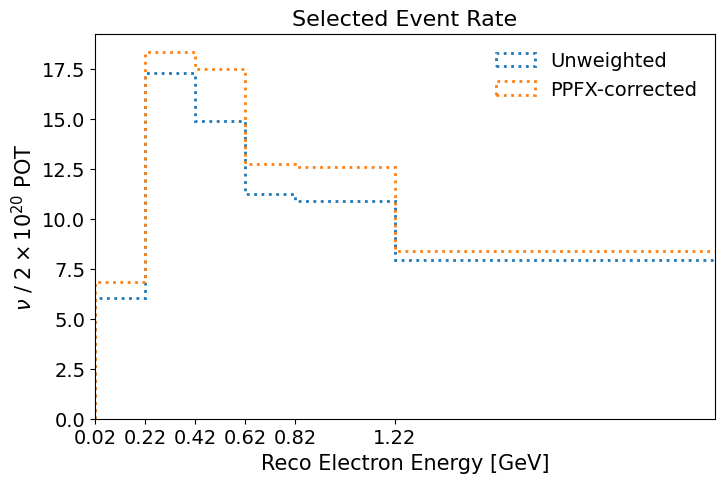

In [36]:
# ppfx correction effect 
fig = plt.figure(figsize=(8, 5))

plt.hist(selected_events[xvar], bins, range=[xlow, xhigh],
            weights=selected_events.pot_scale, linestyle=":", linewidth=2, histtype='step', 
                  label='Unweighted')

plt.hist(selected_events[xvar], bins, range=[xlow, xhigh],
            weights=selected_events.totweight_data, linestyle=":", linewidth=2, histtype='step', 
                  label='PPFX-corrected')


# plot format stuff
plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    
plt.xlabel("Reco "+x_label, fontsize=15)
plt.xticks(x_ticks, fontsize=14)

plt.yticks(fontsize=14)

plt.xlim(xlow, xhigh)
plt.title("Selected Event Rate", fontsize=16)

plt.show()

## Response Matrix & Efficiency 

In [37]:
importlib.reload(xsec_functions)
from xsec_functions import * 

In [38]:
if nuwro: 
    fhc_true_generated = plt.hist(nue.query('is_signal==True')[true_var], bins, 
                                  weights=nue.query('is_signal==True').totweight_data)[0]
    
    fhc_true_selected = plt.hist(signal_df.query(selected_signal_query)[true_var], 
                                 bins, weights=signal_df.query(selected_signal_query).totweight_data)[0]
    
    fhc_true_generated_intrinsic = plt.hist(nue.query('is_signal==True')[true_var], bins, 
                                  weights=nue.query('is_signal==True').ppfx_cv)[0]
    
    plt.close()
    
    
else: 
    if not ISRUN3: 
        with open('unfolding/smearing/FHC_'+xvar+'_021225.json') as f:
            smearing_dict = json.load(f) 
            
        fhc_true_generated = smearing_dict['true_generated']
        fhc_true_selected = smearing_dict['true_selected']
        fhc_true_generated_intrinsic = generated_signal(ISRUN3, true_var, bins, xlow, xhigh, weight='totweight_intrinsic')[0] 
    

Adding pot_scale column using dirt & EXT tune....


In [39]:
if nuwro: 
    save = "fhc_nuwro_smear_eff_"+xvar
    title = "NuWro FHC Response Matrix"

    
else: 
    save = "fhc_genie_smear_eff_"+xvar
    title = "GENIE FHC Response Matrix"

true selected:
[ 1.4956474  11.81034893 14.3014577  11.45049736 11.96769777  8.4267951 ]
59.452444245671494
reco selected: 
[ 4.13952739 14.31354036 14.62043626 10.03634201 10.40919715  5.93340107]
59.45244424567156


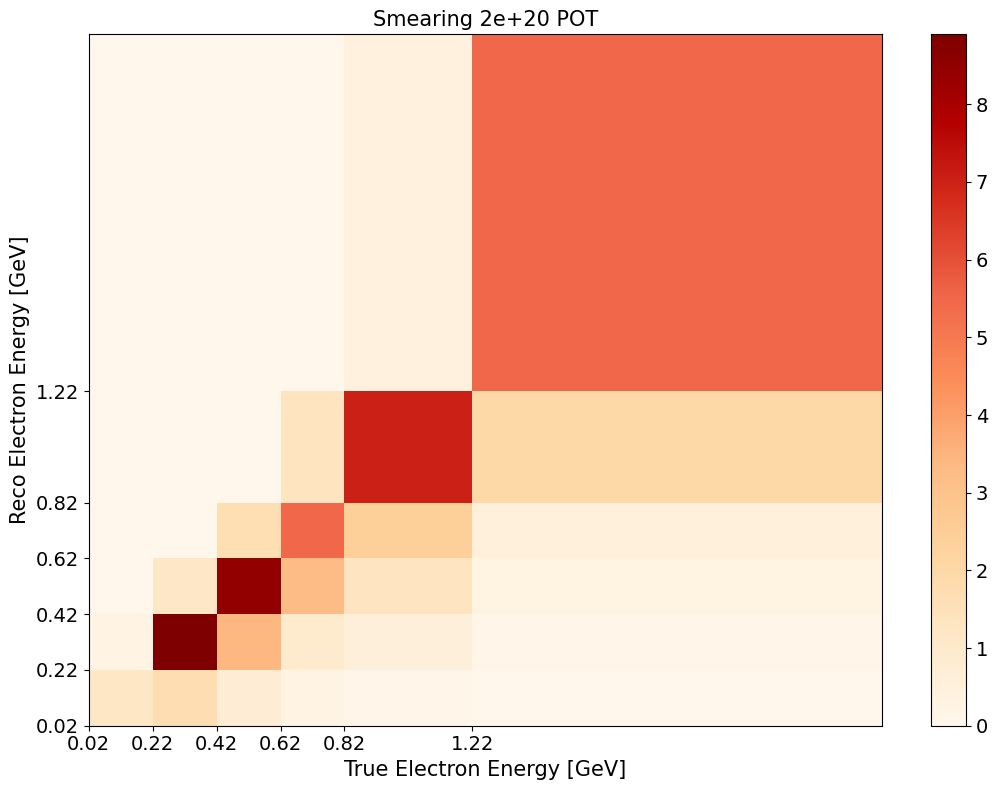

Adding pot_scale column using dirt & EXT tune....


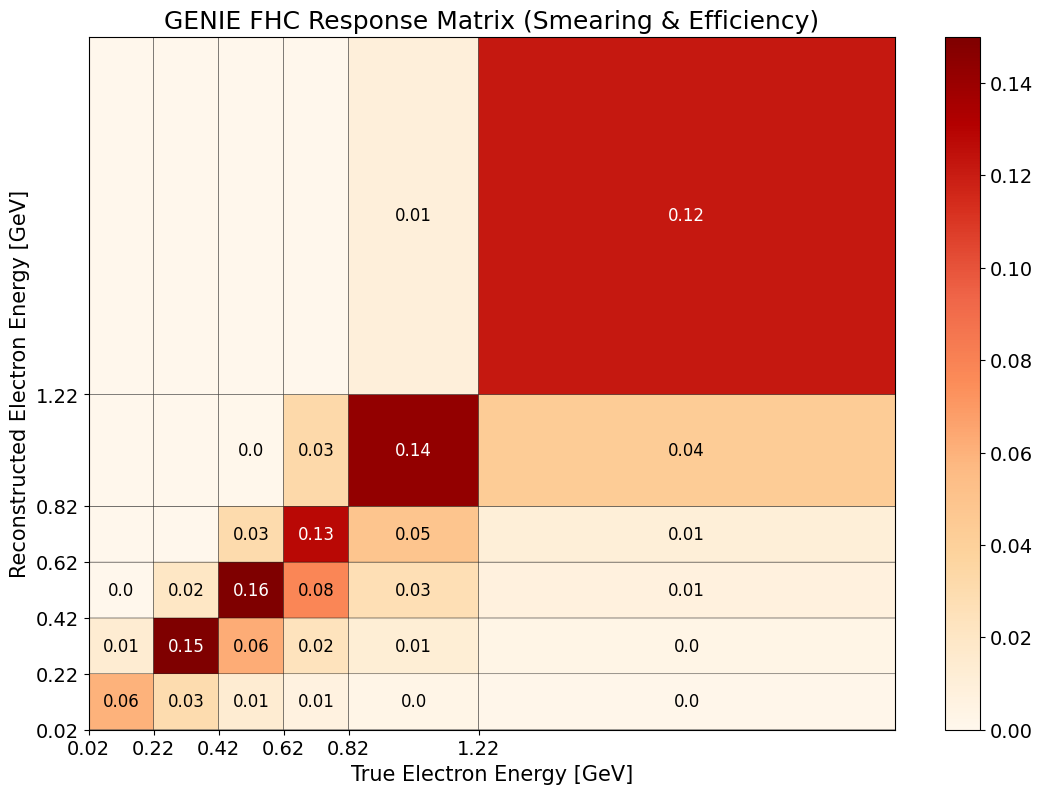

In [40]:
if nuwro: 
    smear_dict = smear_matrix(true_var, xvar, bins, xlow, xhigh, ISRUN3, signal_df.query(selected_signal_query),
                          zmax=10, lbl=x_label, 
                          plot=True, eff=True, x_ticks=x_ticks, title=title, nuwro=True, nuwro_gen=fhc_true_generated)
    
else: 
    smear_dict = smear_matrix(true_var, xvar, bins, xlow, xhigh, ISRUN3, signal_df.query(selected_signal_query),
                          zmax=10, lbl=x_label, 
                          plot=True, eff=True, x_ticks=x_ticks, title=title)

In [41]:
fhc_true_generated

[20.142908250342717,
 57.74156860884486,
 54.433390805954545,
 42.67262499724126,
 49.24522533734634,
 44.969597465876035]

In [42]:
binwidth = []

for x in range(len(bincenters)): 
    binwidth.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))  
    

FHC Efficiency (%) =  [7.3, 20.9, 25.1, 26.200000000000003, 21.7, 15.2]


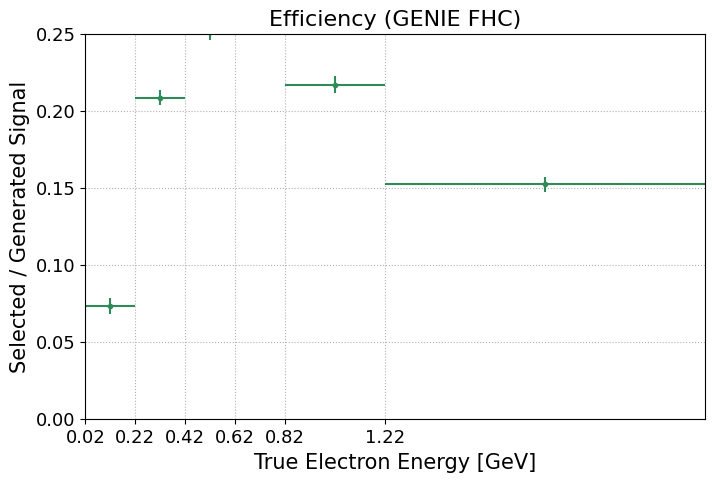

In [43]:
## efficiency 

###########################################################################################

# fhc efficiency 

fhc_eff = [a/b for a,b in zip(fhc_true_selected, fhc_true_generated)]
fhc_eff_err = [ np.sqrt( (x*(1-x)) / y ) for x,y in zip(fhc_eff,fhc_true_generated_intrinsic) ]

print('FHC Efficiency (%) = ', [round(x,3)*100 for x in fhc_eff])


fig = plt.figure(figsize=(8, 5))  

plt.errorbar(bincenters, fhc_eff, yerr=fhc_eff_err, xerr=binwidth, fmt='.', color='seagreen')

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.ylim(0, .25)

plt.xlabel("True " + x_label, fontsize=15)
plt.ylabel("Selected / Generated Signal", fontsize=15)

plt.xlim(bins[0], xhigh)


plt.grid(linestyle=':')

if nuwro: 
    plt.title("Efficiency (NuWro FHC)", fontsize=16)
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fhc_nuwro_eff_"+true_var+".pdf", transparent=True, bbox_inches='tight') 
else: 
    plt.title("Efficiency (GENIE FHC)", fontsize=16)
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fhc_genie_eff_"+true_var+".pdf", transparent=True, bbox_inches='tight') 


plt.show()

In [44]:
fhc_eff

[0.07317493965529336,
 0.2085357782358288,
 0.251110542947041,
 0.26192727918678604,
 0.21702052456277474,
 0.1522628479597394]

## GENIE Background Subtraction

In [45]:
# What file do I need to open here?

with open('unfolding/variations/FHCVariations_'+xvar+'_021225.json') as f_fhc:
        fhc_dict = json.load(f_fhc)


In [46]:
n, b, p = plt.hist(selected_events[xvar], bins, range=[xlow, xhigh],
            weights=selected_events.totweight_data)
plt.close()

In [47]:
len(n)

6

In [48]:
bincenters

array([0.12, 0.32, 0.52, 0.72, 1.02, 1.86])

In [49]:
binwidth = []

for x in range(len(bincenters)):
    
    if xvar=='tksh_angle': 
        binwidth.append(round(abs((x_ticks)[x+1]-(x_ticks)[x])/2, 2))
        
    else: 
        binwidth.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))
    
binwidth

[0.1, 0.1, 0.1, 0.1, 0.2, 0.64]

In [50]:

# Do not include EXT background subtraction! MC only 
cv_bkgd_mc_noext = [a-b for a,b in zip(fhc_dict['cv_bkgd'], fhc_dict['cv_ext'])]

# Also do not include DIRT backgrounds, not in fake data!
cv_bkgd_mc = [a-b for a,b in zip(cv_bkgd_mc_noext, fhc_dict['cv_dirt'])]

# background subtracted event rate - EXT was never added so never subtracted (still need to take into acct its uncertainty)
nuwro_evt_rate = [a - b for a, b in zip(n, cv_bkgd_mc)]

In [51]:
cv_bkgd_mc
len(nuwro_evt_rate)

6

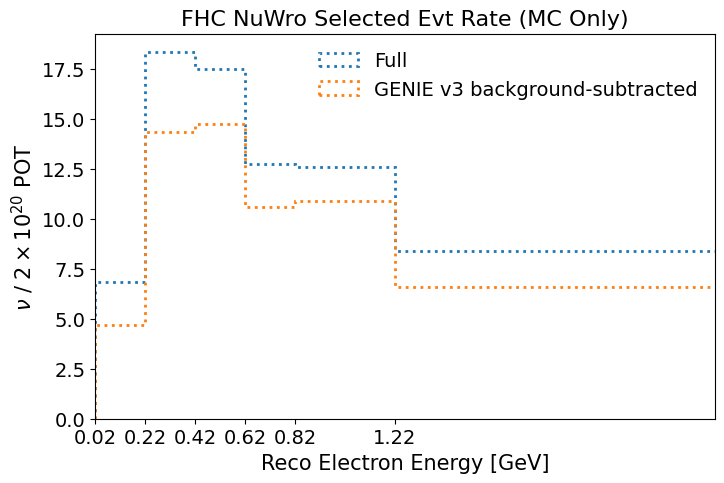

In [52]:

fig = plt.figure(figsize=(8, 5))

plt.hist(selected_events[xvar],
            bins, histtype='step', range=[xlow, xhigh],
            weights=selected_events.totweight_data, linestyle=":", linewidth=2, 
                  label='Full')

plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nuwro_evt_rate, linestyle=":", linewidth=2, 
                  label='GENIE v3 background-subtracted')

# plot format stuff
plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    
plt.xlabel("Reco "+x_label, fontsize=15)
plt.xticks(x_ticks, fontsize=14)

plt.yticks(fontsize=14)
#plt.ylim(0, 7)

plt.xlim(xlow, xhigh)
plt.title("FHC NuWro Selected Evt Rate (MC Only)", fontsize=16)

plt.show()

(array([ 6.84889371, 18.35420183, 17.51495861, 12.72584396, 12.61669874,
         8.38961259]),
 array([0.02, 0.22, 0.42, 0.62, 0.82, 1.22, 7.  ]),
 [<matplotlib.patches.Polygon at 0x39bcba4f0>])

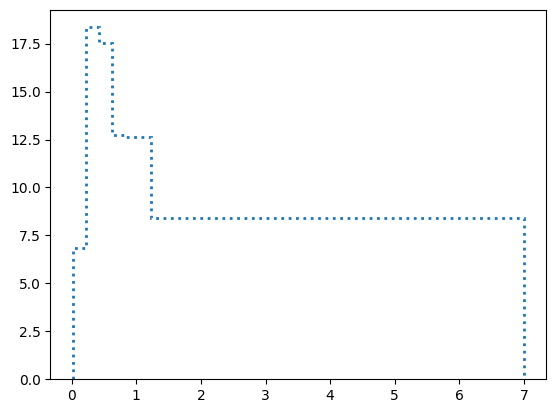

In [53]:
plt.hist(selected_events[xvar],
            bins, histtype='step', range=[xlow, xhigh],
            weights=selected_events.totweight_data, linestyle=":", linewidth=2, 
                  label='Full')

In [54]:
sum(nuwro_evt_rate)

61.83767039783904

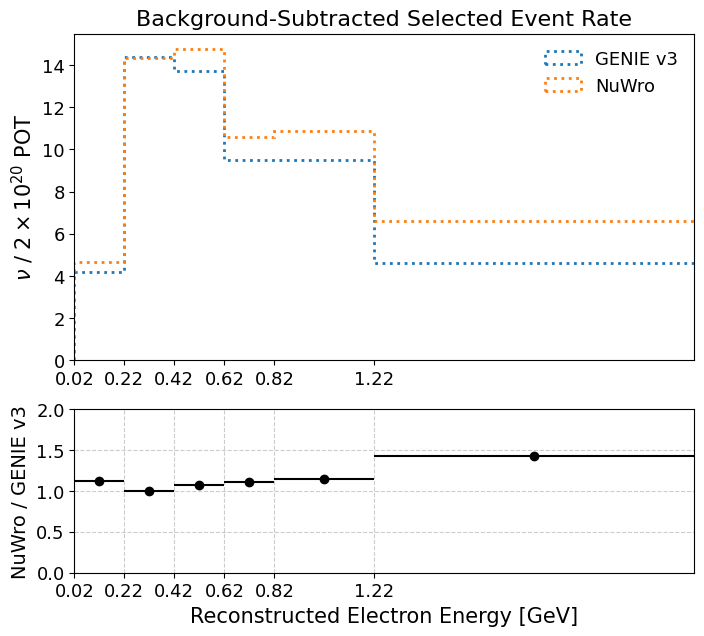

In [55]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

# background subtracted genie evt rate 
ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=fhc_dict['evt_rate'], linestyle=":", linewidth=2, 
                  label='GENIE v3')

# background subtracted nuwro evt rate
ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nuwro_evt_rate, linestyle=":", linewidth=2, 
                  label='NuWro')

# ratio plot  
ax2.errorbar(bincenters, [a/b for a,b in zip(nuwro_evt_rate, fhc_dict['evt_rate'])], 
             xerr=binwidth, color="black", fmt='o')
ax2.set_ylim(0, 2)


# plot formatting 
ax1.set_xlim(xlow,xhigh)
ax1.set_xticks(x_ticks)
ax1.set_ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

ax2.set_xlim(xlow,xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=14)
ax2.set_ylabel("NuWro / GENIE v3", fontsize=14)

ax1.legend(fontsize=13, frameon=False)
    
ax2.set_xlabel("Reconstructed "+x_label, fontsize=15)
ax1.set_title("Background-Subtracted Selected Event Rate", fontsize=16)

#if ISRUN3=='': 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/combined_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_evt_rate_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

In [56]:
# nuwro selected neutrino backgrounds
nuwro_bkgd = pd.concat([datasets_bdt['infv'].query('is_signal==False'), datasets_bdt['outfv']])

In [57]:
nuwro_evt_rate

[4.673398409277576,
 14.340260591852015,
 14.745774304796235,
 10.602377100240206,
 10.88630829999861,
 6.5895516916744015]

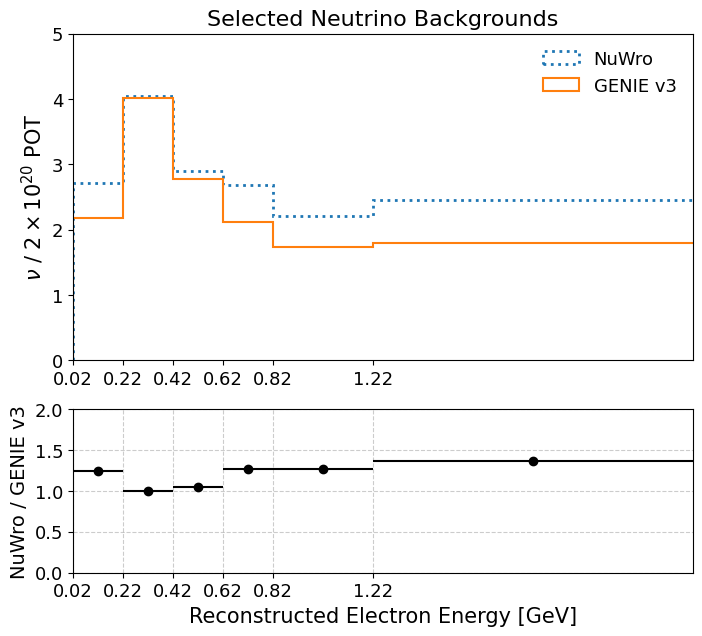

In [58]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

# background subtracted nuwro evt rate
h_nuwro_bkgd = ax1.hist(nuwro_bkgd[xvar], bins, histtype='step', 
                        weights=nuwro_bkgd.totweight_data, range=[xlow,xhigh],  linewidth=2, linestyle=":",
                  label='NuWro')[0]

# genie
ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=cv_bkgd_mc, linewidth=1.5, 
                  label='GENIE v3')



# ratio plot  
ax2.errorbar(bincenters, [a/b for a,b in zip(h_nuwro_bkgd, cv_bkgd_mc)], 
             xerr=binwidth, color="black", fmt='o')
ax2.set_ylim(0, 2)

ax1.set_ylim(0, 5)


# plot formatting 
ax1.set_xlim(xlow,xhigh)
ax1.set_xticks(x_ticks)
ax1.set_ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

ax2.set_xlim(xlow,xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=14)
ax2.set_ylabel("NuWro / GENIE v3", fontsize=14)

ax1.legend(fontsize=13, frameon=False)
    
ax2.set_xlabel("Reconstructed "+x_label, fontsize=15)
ax1.set_title("Selected Neutrino Backgrounds", fontsize=16)


#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_mc_bkgd_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [59]:
genie_true = generated_signal(ISRUN3, true_var, bins, xlow, xhigh)[0]

Adding pot_scale column using dirt & EXT tune....


In [60]:
fhc_dict.keys()

dict_keys(['evt_rate', 'beamon_counts', 'ppfx', 'beamline', 'genie_ms', 'genie_us', 'geant4', 'pot_counting', 'dirt', 'response_matrix', 'cv_dirt', 'cv_bkgd', 'cv_ext', 'mc_bkgd_sumw2', 'ext_sumw2', 'mc_signal_sumw2'])

NameError: name 'generated_events' is not defined

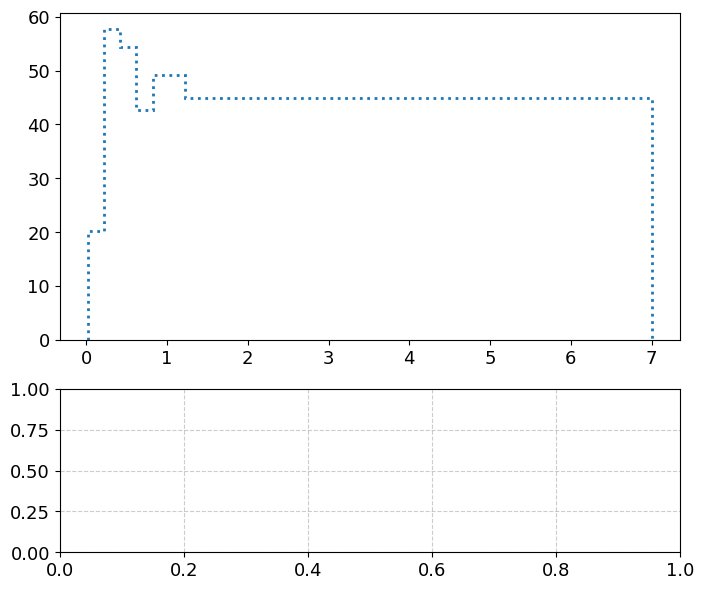

In [61]:
fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
    
ax1.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 13)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax1.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=genie_true, linestyle=":", linewidth=2, 
                  label='GENIE v3')

nuwro_true = ax1.hist(generated_events.query('is_signal==True')[true_var], bins, 
                      histtype='step', range=[xlow,xhigh], 
                      weights=generated_events.query('is_signal==True')['totweight_data'], 
                      linestyle=":", linewidth=2, 
                  label='NuWro')[0]


# ratio plot  
ax2.errorbar(bincenters, [a/b for a,b in zip(nuwro_true, genie_true)], 
             xerr=binwidth, color="black", fmt='o')
ax2.set_ylim(0, 2)


# plot formatting 
ax1.set_xlim(xlow,xhigh)
ax1.set_xticks(x_ticks)
ax1.set_ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)

ax2.set_xlim(xlow,xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=14)
ax2.set_ylabel("NuWro / GENIE v3", fontsize=14)

ax1.legend(fontsize=13, frameon=False)
    
ax2.set_xlabel("True "+x_label, fontsize=15)
ax1.set_title("Generated Signal Event Rate", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_gen_signal_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')
plt.show()

[20.142908250342717, 57.74156860884486, 54.433390805954545, 42.67262499724126, 49.24522533734634, 44.969597465876035]


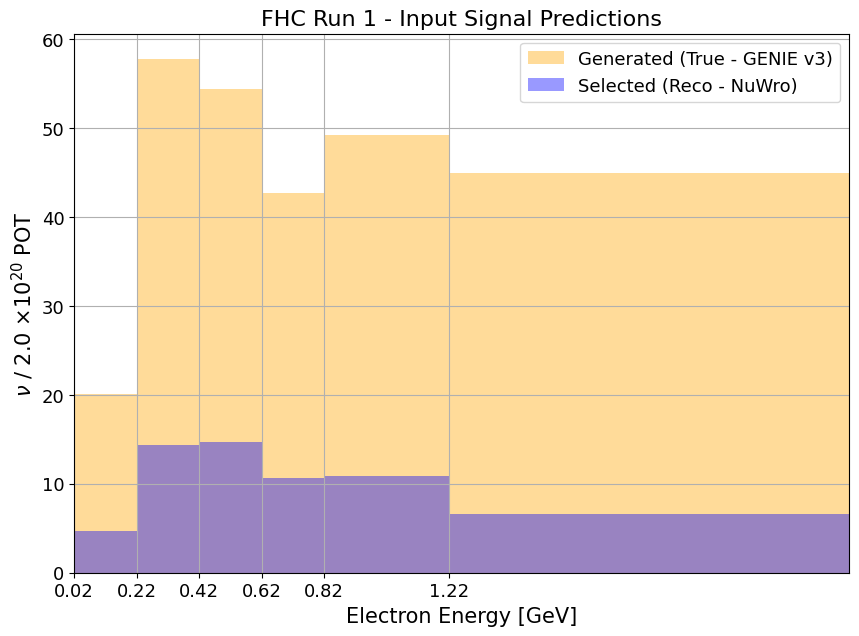

In [62]:
# nuwro input distributions 

fig = plt.figure(figsize=(10, 7))

print(genie_true)


plt.hist(bincenters, bins, color='orange', label='Generated (True - GENIE v3)', alpha=0.4, 
         weights=genie_true)

# genie background subtracted evt rate 
plt.hist(bincenters, bins, color='blue', label='Selected (Reco - NuWro)', alpha=0.4, weights=nuwro_evt_rate)

plt.legend(fontsize=13)
plt.title('FHC Run 1 - Input Signal Predictions', fontsize=16)

plt.xlim(xlow, xhigh)

plt.xlabel(x_label, fontsize=15)
    
plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.ylabel("$\\nu$ / 2.0 $\\times 10^{20}$ POT", fontsize=15)

plt.grid()

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_input_dist_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()


In [63]:
nuwro_evt_rate

[4.673398409277576,
 14.340260591852015,
 14.745774304796235,
 10.602377100240206,
 10.88630829999861,
 6.5895516916744015]

In [64]:
# sumw2 of the full event rate 
nuwro_full_sumw2 = []

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    nuwro_full_sumw2.append(sum(selected_events.query(bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )


[0.13095238490604955, 0.04677361546666406, 0.044394639005200756, 0.05198412472063848, 0.04892223409663095, 0.06211927790495725]


In [65]:
nuwro_full_sumw2

[0.37453502484247736,
 0.44989997465342996,
 0.42854479296781384,
 0.30377215756864473,
 0.2836441439122315,
 0.1675577560882111]

## NuWro Systematic - Signal Region

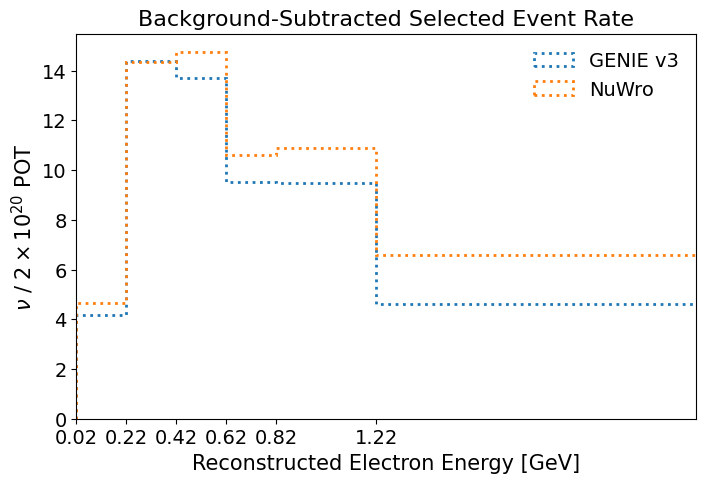

In [66]:
# genie vs nuwro event rate

fig = plt.figure(figsize=(8, 5))

# background subtracted genie evt rate 
plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=fhc_dict['evt_rate'], linestyle=":", linewidth=2, 
                  label='GENIE v3')

# background subtracted nuwro evt rate
plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=nuwro_evt_rate, linestyle=":", linewidth=2, 
                  label='NuWro')

# plot format stuff
plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.xticks(x_ticks, fontsize=14)

plt.yticks(fontsize=14)

plt.xlim(xlow, xhigh)


plt.title("Background-Subtracted Selected Event Rate", fontsize=16)

plt.show()

number of universes =  1


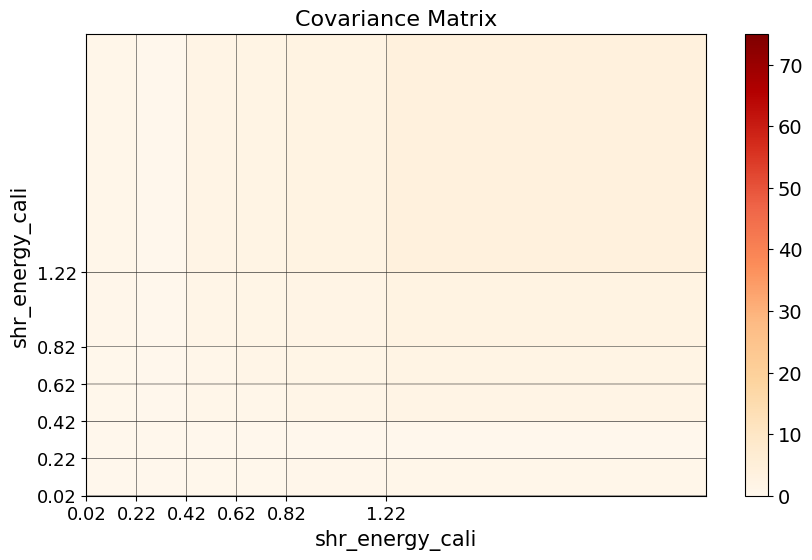

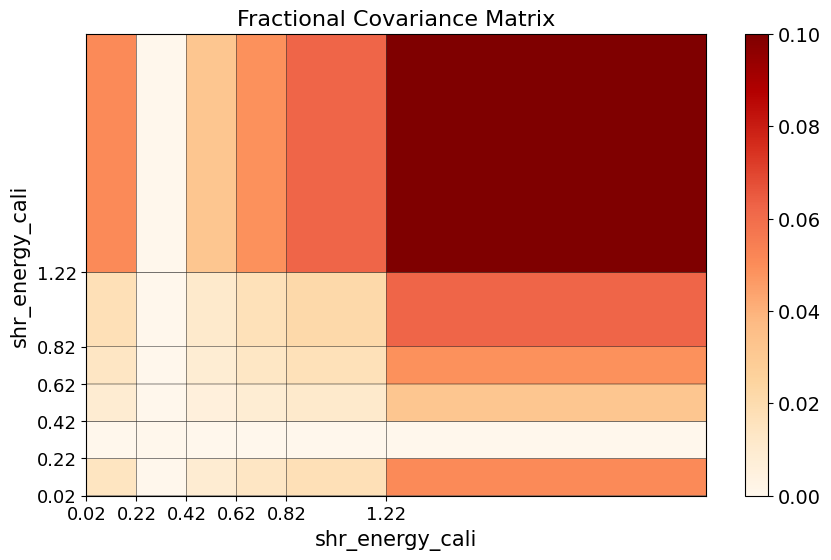

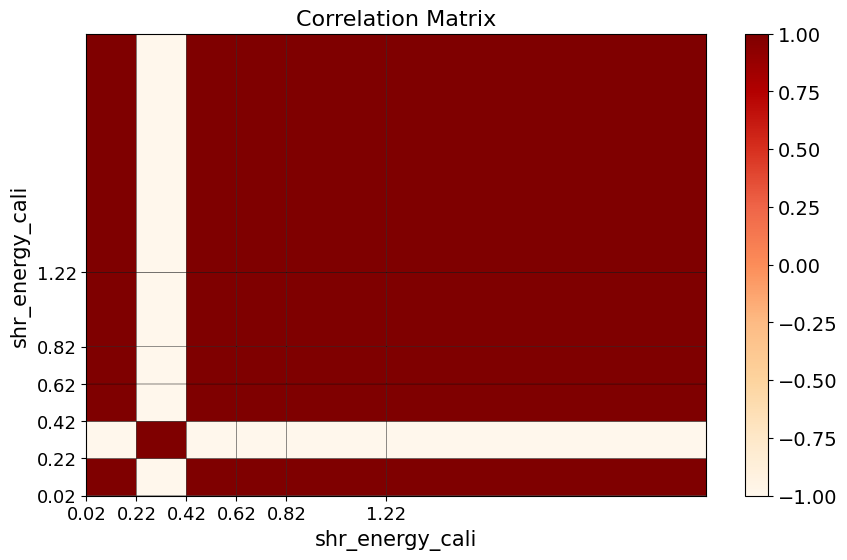

In [67]:
cov_dict = calcCov(xvar, bins, fhc_dict['evt_rate'], fhc_dict['evt_rate'], [nuwro_evt_rate], 
        plot=True, save=False, axis_label=None, pot=None, isrun3=False, xticks=x_ticks, xhigh=xhigh)

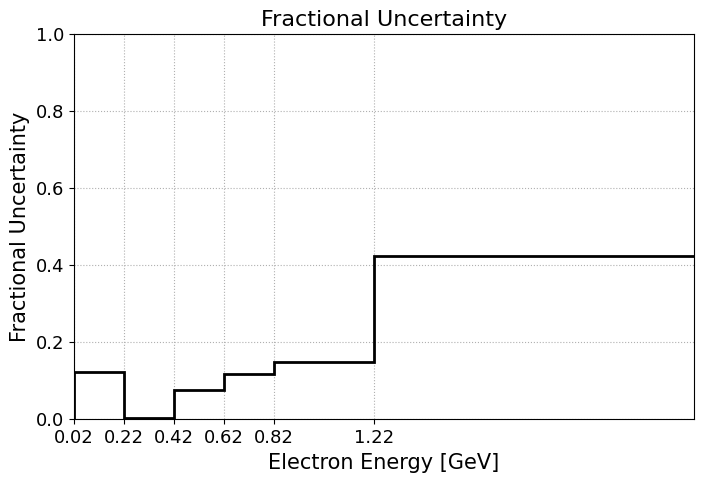

In [68]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', weights=cov_dict['fractional_uncertainty'], color='black', 
        linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1)

plt.title("Fractional Uncertainty", fontsize=16)
plt.grid(linestyle=":")
plt.show()

In [69]:
# genie_evt_rate - background subtracted event rate 
# nuwro_evt_rate - background subtracted event rate 
# genie_nu_bkgd - neutrino background prediction from genie 
# nuwro_nu_bkgd - neutrino background prediction from nuwro

sys_dict = {}

In [70]:
sys_dict['genie_evt_rate'] = fhc_dict['evt_rate']
sys_dict['nuwro_evt_rate'] = nuwro_evt_rate
sys_dict['genie_nu_bkgd'] = cv_bkgd_mc
sys_dict['nuwro_nu_bkgd'] = list(h_nuwro_bkgd)
sys_dict['cov'] = cov_dict['cov']
sys_dict['frac_cov'] = cov_dict['frac_cov']
sys_dict['cor'] = cov_dict['cor']
sys_dict['fractional_uncertainty'] = list(cov_dict['fractional_uncertainty'])

In [71]:
#with open('unfolding/nuwro_sys/'+xvar+'.json', "w") as f:
#    json.dump(sys_dict, f) 

## Save to File

In [72]:
fhc_dict.keys()

dict_keys(['evt_rate', 'beamon_counts', 'ppfx', 'beamline', 'genie_ms', 'genie_us', 'geant4', 'pot_counting', 'dirt', 'response_matrix', 'cv_dirt', 'cv_bkgd', 'cv_ext', 'mc_bkgd_sumw2', 'ext_sumw2', 'mc_signal_sumw2'])

In [73]:
# Uncommented out the last two lines 
# Changed the name of the first two to match what's in combined.ipynb

fhc_dict['nuwro_full_sumw2'] = nuwro_full_sumw2
fhc_dict['evt_rate_nuwro_ppfx'] = nuwro_evt_rate # background subtracted event rate (reco dist)
fhc_dict['nuwro_generated_signal_ppfx'] = list(nuwro_true) # generated truth (true distribution)
fhc_dict['genie_generated_signal_ppfx'] = list(genie_true) # generated truth (true distribution)

NameError: name 'nuwro_true' is not defined

In [74]:
nuwro_true

NameError: name 'nuwro_true' is not defined

In [75]:
genie_true

[20.142908250342717,
 57.74156860884486,
 54.433390805954545,
 42.67262499724126,
 49.24522533734634,
 44.969597465876035]

In [76]:
fhc_dict.keys()

dict_keys(['evt_rate', 'beamon_counts', 'ppfx', 'beamline', 'genie_ms', 'genie_us', 'geant4', 'pot_counting', 'dirt', 'response_matrix', 'cv_dirt', 'cv_bkgd', 'cv_ext', 'mc_bkgd_sumw2', 'ext_sumw2', 'mc_signal_sumw2', 'nuwro_full_sumw2', 'evt_rate_nuwro_ppfx'])

In [77]:
f_fhc.close()

In [78]:
# Which file do I use for this?

with open('unfolding/variations/FHCVariations_'+xvar+'_021225.json', "w") as f_fhc:
        json.dump(fhc_dict, f_fhc)

## Replace Distributions -- Ignore For Now

In [ ]:
# reco distribution (MC or data)
hreco = TH1D("hmeas", "Selected NuWro Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    hreco.Fill(bincenters[i], fhc_dict['evt_rate_nuwro_ppfx'][i])


In [ ]:
# Is this updating an old file, or creating a new one?

f = ROOT.TFile.Open('/uboone/data/users/kmiller/uBNuMI_CCNp/unfolding/fakedata/input/WSVD_'+xvar+'_FHC_NuWroToGENIE_ppfx.root', "UPDATE")


In [ ]:
f.cd()
hreco.Write()

f.Close()

In [ ]:
# generated signal 

htrue_signal = TH1F("htrue_signal", "Generated NuWro MC Signal vs. True "+x_label+" ("+true_var+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    htrue_signal.Fill(bincenters[i], fhc_dict['nuwro_generated_signal_ppfx'][i])
    print(fhc_dict['nuwro_generated_signal_ppfx'][i])

In [ ]:
# Is this updating an old file, or creating a new one?

f = ROOT.TFile.Open('/uboone/data/users/kmiller/uBNuMI_CCNp/unfolding/fakedata/input/WSVD_'+xvar+'_FHC_NuWroToNuWro_ppfx.root', "UPDATE")


In [ ]:
f.cd()
#hreco.Write()
htrue_signal.Write()

f.Close()

# NuWro Sideband -- Outdated 

In [ ]:
# genie_evt_rate - background subtracted event rate 
# nuwro_evt_rate - background subtracted event rate 
# genie_nu_bkgd - neutrino background prediction from genie 
# nuwro_nu_bkgd - neutrino background prediction from nuwro 

In [ ]:
#with open('unfolding/NuWroNearSideBand_tksh_angle.json') as f_sideband:
#    sideband_dict = json.load(f_sideband)

In [ ]:
# genie vs nuwro event rate

fig = plt.figure(figsize=(8, 5))

# background subtracted genie evt rate 
plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=sideband_dict['genie_evt_rate'], linestyle=":", linewidth=2, 
                  label='GENIE v3')

# background subtracted nuwro evt rate
plt.hist(bincenters, bins, histtype='step', range=[xlow,xhigh], 
        weights=sideband_dict['nuwro_evt_rate'], linestyle=":", linewidth=2, 
                  label='NuWro')

# plot format stuff
plt.legend(loc='best', prop={"size":14}, ncol=1, frameon=False)

plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
    
plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.xticks(x_ticks, fontsize=14)

plt.yticks(fontsize=14)

plt.xlim(xlow, xhigh)
plt.ylim(0, 7)

plt.title("Background-Subtracted Selected Event Rate", fontsize=16)

plt.show()

In [ ]:
cov_dict = calcCov(xvar, bins, sideband_dict['genie_evt_rate'], sideband_dict['genie_evt_rate'], [sideband_dict['nuwro_evt_rate']], 
        plot=True, save=False, axis_label=None, pot=None, isrun3=False, xticks=x_ticks, xhigh=xhigh)

In [ ]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', weights=cov_dict['fractional_uncertainty'], color='black', 
        linewidth=2)

plt.xticks(x_ticks[:-1], fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1)

plt.title("Fractional Uncertainty", fontsize=16)
plt.grid(linestyle=":")
plt.show()

In [ ]:
sideband_dict['cov'] = cov_dict['cov']
sideband_dict['frac_cov'] = cov_dict['frac_cov']
sideband_dict['cor'] = cov_dict['cor']
sideband_dict['fractional_uncertainty'] = list(cov_dict['fractional_uncertainty'])

In [ ]:
sideband_dict

In [ ]:
f_sideband.close()

In [ ]:
with open('unfolding/NuWroNearSideBand_tksh_angle.json', "w") as f_sideband:
    json.dump(sideband_dict, f_sideband) 